## TC bulk properties
This notebook logs bulk properties of TCs from provided runs. Bulk properties include:
- TC frequency
- TC intensity
- TC duration
- TC spatial distribution

In [1]:
''' Import packages. '''
# Time packages
import calendar, cftime, datetime, time
# Numerical analysis packages
import numpy as np, random, scipy, numba
# Local data storage packages
import functools, importlib, os, pickle, collections, sys

import pandas as pd, xarray as xr, nc_time_axis
xr.set_options(keep_attrs=True)
# Visualization tools
import cartopy, cartopy.util as cutil, cartopy.crs as ccrs, matplotlib, matplotlib.pyplot as plt

import analysis, visualization_aqp
importlib.reload(analysis)
importlib.reload(visualization_aqp)

# Local imports
sys.path.insert(1, '/projects/GEOCLIM/gr7610/scripts')
import derived, utilities, visualization, track_TCs, tc_analysis
importlib.reload(track_TCs);
importlib.reload(tc_analysis);
importlib.reload(utilities);

### ACE/PDI/frequency troubleshooting

In [207]:
importlib.reload(visualization)
TMP_A = track_data['AM2.5-CTL1990.AMIP']['raw'].copy()
TMP_B = TMP_A.groupby('storm_id').apply(lambda x: ((x['max_wind']**3).sum())).rename('PDI').reset_index()
TMP_C = pd.merge(TMP_A, TMP_B, on='storm_id', how='left').groupby('storm_id').first().reset_index()

bins = pd.cut(TMP_C.center_lat, np.arange(-90, 90, 5))
TMP_D = TMP_C.copy()['PDI'].groupby(bins).sum().reset_index()
TMP_D.index = TMP_D['center_lat'].apply(lambda x: x.left)

NUM_YEARS = np.round((TMP_C['cftime'].max() - TMP_C['cftime'].min()).days / 365).astype(int) # number of years

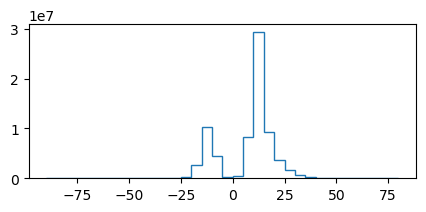

In [202]:
fig, ax = plt.subplots(figsize=(5, 2))
ax.stairs(TMP_D['PDI'][:-1] / NUM_YEARS, TMP_D.index)

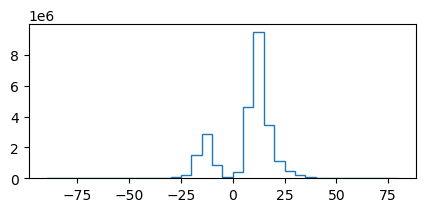

In [206]:
fig, ax = plt.subplots(figsize=(5, 2))
ax.stairs(TMP_D['PDI'][:-1] / 45, TMP_D.index)

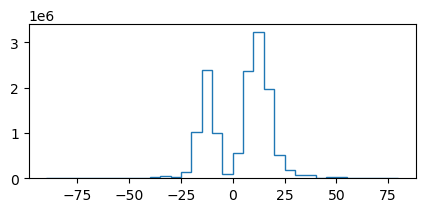

In [210]:
fig, ax = plt.subplots(figsize=(5, 2))
ax.stairs(TMP_D['PDI'][:-1] / 45, TMP_D.index)

### Load configurations

#### For non-saved data

In [243]:
importlib.reload(analysis)

model_name = 'HIRAM'
experiment_name = 'AMIP'

experiment_configurations = {f'AM2.5-CTL1990.CONST': (2, 7),
                             f'AM2.5-CTL1990_SWISHE.CONST': (2, 7),
                             f'AM2.5-CTL1990.0N': (2, 16),
                             f'AM2.5-CTL1990_SWISHE.0N': (2, 16),
                             f'AM2.5-CTL1990.15N': (2, 16),
                             f'AM2.5-CTL1990_SWISHE.15N': (2, 16),
                             f'AM2.5-CTL1990.TIMEVAR': (5, 25),
                             f'AM2.5-CTL1990_SWISHE.TIMEVAR': (5, 25),
                             f'AM2.5-CTL1990.AMIP': (101, 125),
                             f'AM2.5-CTL1990_SWISHE.AMIP': (101, 125)}
track_data = analysis.load_TC_track_data(experiment_configurations=experiment_configurations, diagnostic=True)

for configuration_name in track_data.keys():
    TMP = track_data[configuration_name]['unique']
    hurricane_percentage = len(TMP.loc[TMP['max_wind'] >= 29.5])/np.around((TMP.time.max() - TMP.time.min()).days / 365)
    print(f'Number of hurricane-strength TCs in {configuration_name} per year: {hurricane_percentage:.2f}')
del TMP

[load_TC_track_data()] Preloaded data being used...
[load_TC_track_data()] Number of storms per year, experiment CTL1990.CONST: 514.33
	#######################################################
[load_TC_track_data()] Preloaded data being used...
[load_TC_track_data()] Number of storms per year, experiment CTL1990_SWISHE.CONST: 413.17
	#######################################################
[load_TC_track_data()] Preloaded data being used...
[load_TC_track_data()] Number of storms per year, experiment CTL1990.0N: 60.60
	#######################################################
[load_TC_track_data()] Preloaded data being used...
[load_TC_track_data()] Number of storms per year, experiment CTL1990_SWISHE.0N: 23.20
	#######################################################
[load_TC_track_data()] Preloaded data being used...
[load_TC_track_data()] Number of storms per year, experiment CTL1990.15N: 113.27
	#######################################################
[load_TC_track_data()] Preloaded dat

#### Run to load statistics for tracked TCs, publication quality

In [2]:
importlib.reload(analysis)
experiment_configurations = {f'AM2.5-CTL1990.CONST': (2, 7),
                             f'AM2.5-CTL1990_SWISHE.CONST': (2, 7),
                             f'AM2.5-CTL1990.0N': (2, 16),
                             f'AM2.5-CTL1990_SWISHE.0N': (2, 16),
                             f'AM2.5-CTL1990.15N': (2, 16),
                             f'AM2.5-CTL1990_SWISHE.15N': (2, 16),
                             f'AM2.5-CTL1990.TIMEVAR': (5, 25),
                             f'AM2.5-CTL1990_SWISHE.TIMEVAR': (5, 25),
                             f'AM2.5-CTL1990.AMIP': (101, 125),
                             f'AM2.5-CTL1990_SWISHE.AMIP': (101, 125),
                             f'HIRAM-CTL1990.CONST': (2, 7),
                             f'HIRAM-CTL1990_SWISHE.CONST': (2, 7),
                             f'HIRAM-CTL1990.0N': (2, 16),
                             f'HIRAM-CTL1990_SWISHE.0N': (2, 16),
                             f'HIRAM-CTL1990.15N': (2, 16),
                             f'HIRAM-CTL1990_SWISHE.15N': (2, 16),
                             f'HIRAM-CTL1990.TIMEVAR': (5, 25),
                             f'HIRAM-CTL1990_SWISHE.TIMEVAR': (5, 25),
                             f'HIRAM-CTL1990.AMIP': (101, 125),
                             f'HIRAM-CTL1990_SWISHE.AMIP': (101, 125),
                             'IBTrACS': (1980, 2025)}
track_data = analysis.load_TC_track_data(experiment_configurations=experiment_configurations, diagnostic=False)
statistics_TC = analysis.get_TC_statistics(experiment_configurations, diagnostic=False)

# Reassign IBTrACS data to corresponding models as an observational dataset
if 'AM2.5' in ''.join(list(track_data.keys())): track_data['AM2.5-IBTrACS.AMIP'] = track_data['IBTrACS'] 
if 'HIRAM' in ''.join(list(track_data.keys())): track_data['HIRAM-IBTrACS.AMIP'] = track_data['IBTrACS'] 
del track_data['IBTrACS']

Path for model IBTrACS and experiment  not found. Returning None.
Path for model IBTrACS and experiment  not found. Returning None.


#### Plot the distribution of a parameter

##### Center latitude

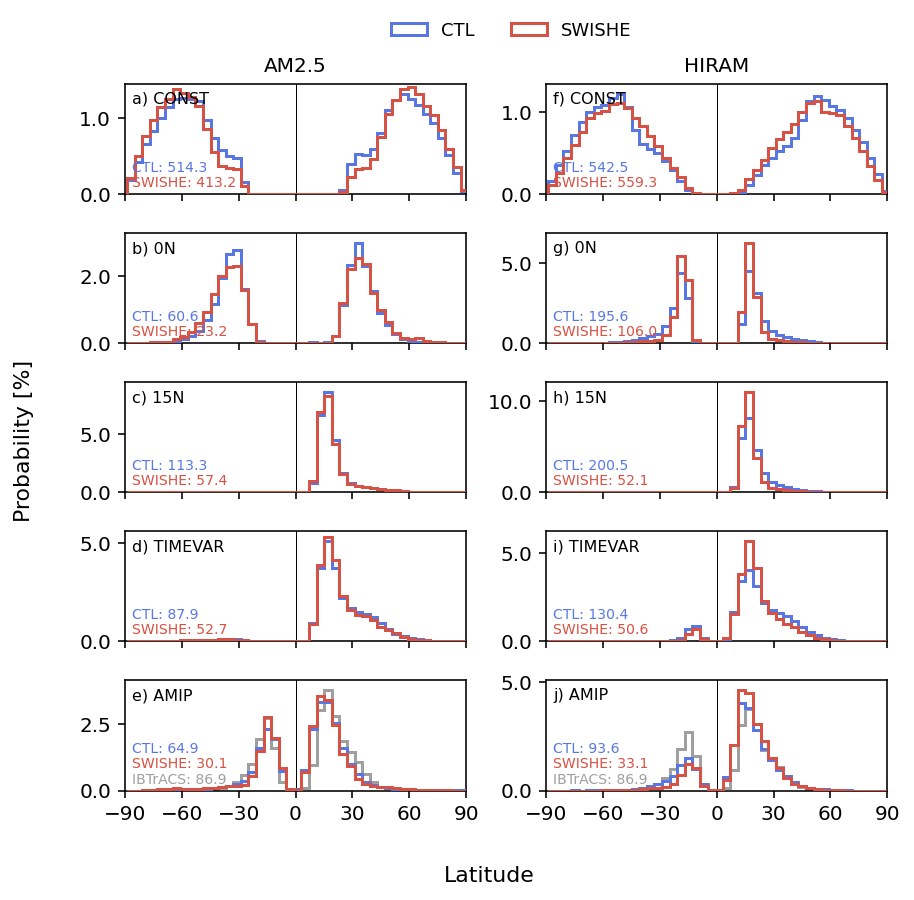

In [3]:
importlib.reload(visualization_aqp)
visualization_aqp.TC_parameter_distribution(track_data=track_data, 
                                            distribution_parameter='center_lat',
                                            sampling_method='all',
                                            label_start_index=0,
                                            savefig=False,
                                            diagnostic=False)

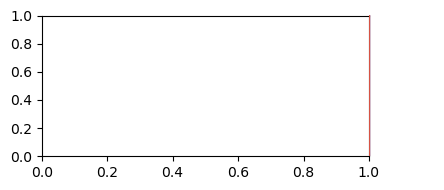

In [19]:
fig, ax = plt.subplots(figsize=(4, 2))
model_name = 'AM2.5'
experiment_names = ['CTL1990.0N', 'CTL1990_SWISHE.0N']
fig.tight_layout()
density_TCs = visualization.TC_density_histogram(ax=ax,
                                                 model_name=model_name,
                                                 experiment_names=experiment_names,
                                                 bin_size=5,
                                                 axis_depth=0.2,
                                                 orientation='horizontal',
                                                 basin_name=None,
                                                 diagnostic=False)

#### 2D TC density comparison

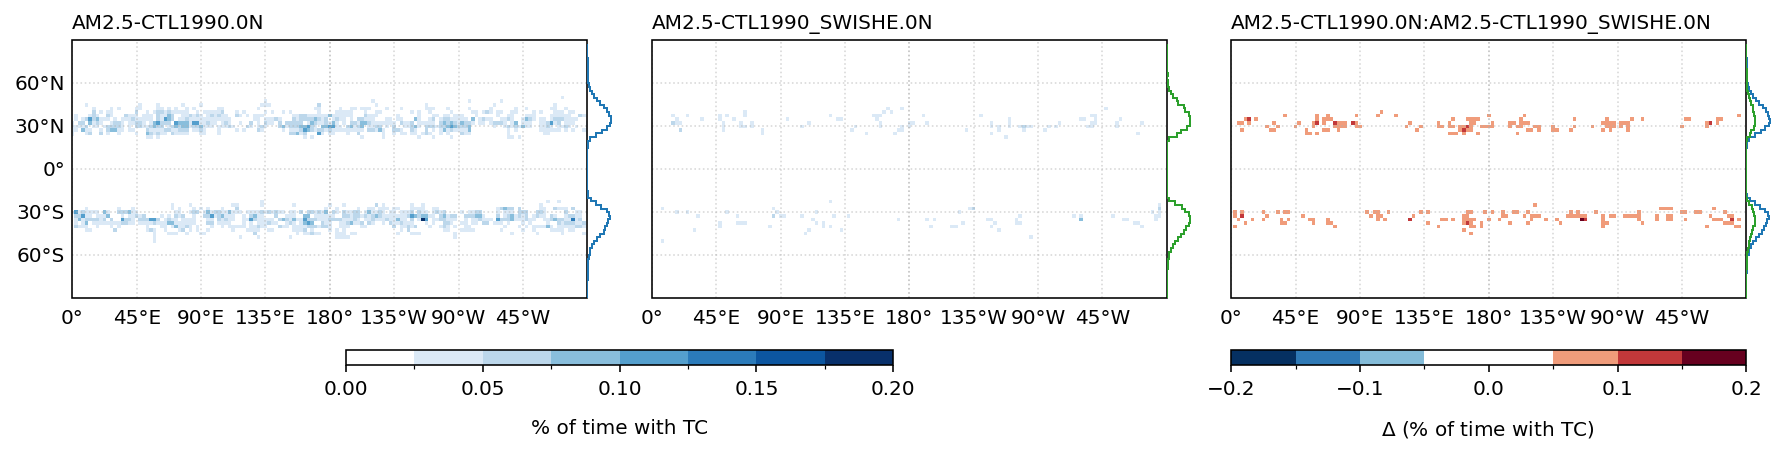

In [20]:
importlib.reload(visualization_aqp)
density_model_name = 'AM2.5'
density_config_name = '0N'
visualization_aqp.TC_track_density(track_data=track_data, 
                                   experiment_comparison=f'{density_model_name}-CTL1990.{density_config_name}:{density_model_name}-CTL1990_SWISHE.{density_config_name}',
                                   bin_resolution=2.5,
                                   add_land=False,
                                   savefig=False)

#### TC frequency with respect to model year

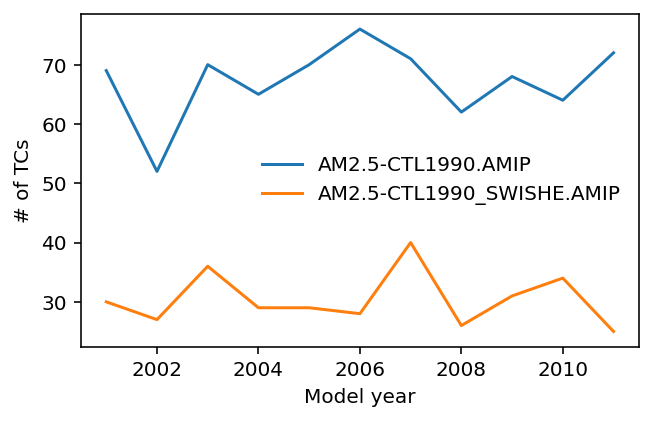

In [67]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=144)
for configuration_name in track_data.keys():
    TMP = track_data[configuration_name]['unique']
    TMP['center_lat'].groupby(TMP.time.dt.year).count().plot(ax=ax, label=configuration_name.upper())

# ax.set_xticks
ax.set_xlabel('Model year')
ax.set_ylabel('# of TCs')
ax.legend(frameon=False)

#### TC tracks

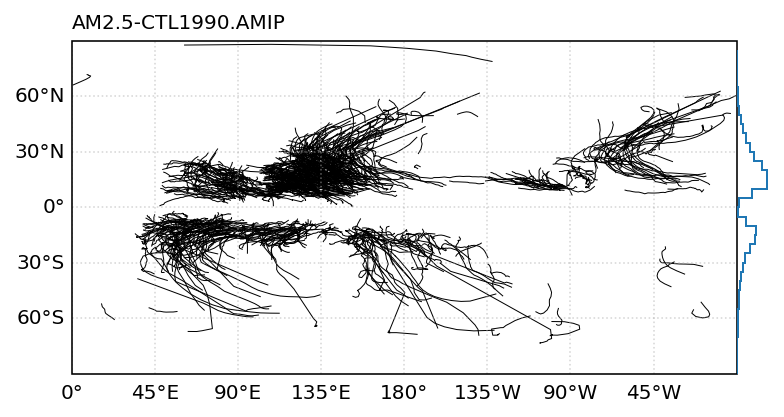

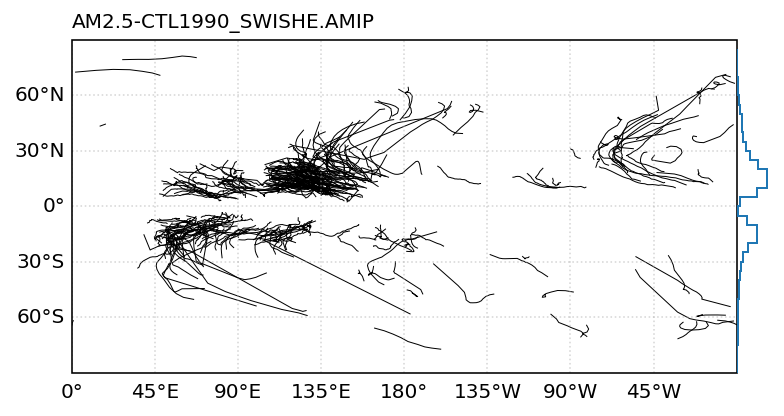

In [16]:
importlib.reload(visualization_aqp)
for configuration_name in track_data.keys():
    visualization_aqp.TC_tracks_raw(track_data=track_data,
                                    configuration_name=configuration_name)